In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, goodness=None, value=None): 
        
        # decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.goodness = goodness
        
        # leaf node
        self.value = value

class DecisionTree():
    def __init__(self, min_samples_split=2, max_depth=2):
        # constructor
        
        # initializes the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_dt(self, X, y):
      # asked function in the homework. Calls recursive function which constructs the classification tree
      self.root = self.build_tree('classifier', X, y)

    def build_rdf(self, X, y):
      # asked function in the homework. Calls recursive function which constructs the regression tree
      self.root = self.build_tree('regressor', X, y)
      
    def build_tree(self, task, X, y, curr_depth=0):         
        # bulids the tree
        y = np.reshape(y, (len(y), 1))
        dataset = np.concatenate((X, y), axis=1)
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(task, dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["goodness"]>0:
                # recur left
                X_l_split, y_l_split = best_split["dataset_left"][:,:-1], best_split["dataset_left"][:,-1]
                left_subtree = self.build_tree(task, X_l_split, y_l_split, curr_depth+1)
                # recur right
                X_r_split, y_r_split = best_split["dataset_right"][:,:-1], best_split["dataset_right"][:,-1]
                right_subtree = self.build_tree(task, X_r_split, y_r_split, curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["goodness"])
        
        # computes leaf node
        leaf_value = self.calculate_leaf_value(y)
        # returns leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, task, dataset, num_samples, num_features):
        # finds the best split
        
        # dictionary to store the best split
        best_split = {}
        max = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                  if (task == 'classifier'):
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    goodness = self.information_gain(y, left_y, right_y)
                    # update the best split if needed
                    if goodness>max:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["goodness"] = goodness
                        max = goodness
                  if (task == 'regressor'):
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    goodness = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if goodness>max:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["goodness"] = goodness
                        max = goodness
                        
        # returns best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        # splits the data to its left and rigth trees according to threshold value
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child):
        # calculates information gain
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)

        return self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
    
    def variance_reduction(self, parent, l_child, r_child):
        # calculates variance reduction
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction

    def entropy(self, y):
        # calculates entropy
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def calculate_leaf_value(self, Y):
        # calculates leaf node
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        # prints the tree
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.goodness)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
        
    
    def predict(self, X, task):
        # predicts the class values of X
        
        if(task == 'classifier'):
          predictions = [self.predict_dt(self.root, x) for x in X]
        elif (task == 'regressor'):
          # Calculate the R2 score
          predictions = [self.predict_rdf(self.root, x) for x in X]
        else:
          print("Unexpected task type!")
          return 0;
          
        return predictions
    
    def predict_dt(self, dt, X):
        # predicts the class values of X according  to built decision tree
        
        if dt.value!=None: return dt.value
        feature_val = X[dt.feature_index]
        if feature_val<=dt.threshold:
            return self.predict_dt(dt.left, X)
        else:
            return self.predict_dt(dt.right, X)

    def predict_rdf(self, rdf, X):
      # predicts the class values of X according  to built decision tree
        
        if rdf.value!=None: return rdf.value
        feature_val = X[rdf.feature_index]
        if feature_val<=rdf.threshold:
            return self.predict_rdf(rdf.left, X)
        else:
            return self.predict_rdf(rdf.right, X)

    def score(self, y, predictions, task):
        # calculates the accuracy score between 0 and 1
        true_number = 0

        if(task == 'classifier'):
          return accuracy_score(y, predictions)
        elif (task == 'regressor'):
          # Calculate the R2 score
          return r2_score(y, predictions)
        else:
          print("Unexpected task type!")
          return 0;


def cross_validation(model, X, y, k_val, task):
  # Define the number of folds for k-fold cross-validation
  k = k_val

  X = np.concatenate((X, y), axis=1)

  # Shuffle the indices of your data
  indices = np.random.permutation(len(X))

  # Split the indices into k folds
  folds = np.array_split(indices, k)

  # Initialize an empty array to store the cross-validation scores
  cv_scores = np.zeros(k)

  # Loop through each fold in the cross-validation
  for i in range(k):
      # Get the training and testing indices for this fold
      test_indices = folds[i]
      train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
      
      # Split the training and testing data to their classes and values
      X_train, y_train = X[train_indices], y[train_indices]
      X_test, y_test = X[test_indices], y[test_indices]
      
      # Train your model on the training data
      if(task == 'classifier'):
        model.build_dt(X_train, y_train)
      elif(task == 'regressor'):
        model.build_rdf(X_train, y_train)
      else:
        print('Unexpected task type!')
        return

      y_predict = model.predict(X_test, task)
      
      # Calculate the cross-validation score on the testing data
      cv_scores[i] = model.score(y_test, y_predict, task)
  # Calculate the average cross-validation score and print it
  print("Average cross-validation score: {:.2f}".format(np.mean(cv_scores)))


def classification():
  # implements classification
  df = pd.read_csv("/content/audit_risk.csv")

  df = df.apply(pd.to_numeric, errors='coerce') # Converts nonnumeric values to NaN so that we can discard them later
  df = df.dropna()  # Drops missing records


  X = df.iloc[:, :-1].values # attributes
  y = df.iloc[:, -1].values.reshape(-1,1)  # classes


  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)  # Splits the data into train set, test set and their classes

  print('\n\nCLASSIFICATION\n\n')

  classifier = DecisionTree(min_samples_split=3, max_depth=3) 
  classifier.build_dt(X_train,y_train)
  classifier.print_tree()

  task = 'classifier'

  cv_val = 6

  # Perform k-fold cross-validation
  cross_validation(classifier, X_train, y_train, cv_val, task)

  y_pred = classifier.predict(X_test, task) 
  
  # Shows confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  print('Confusion matrix:\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])

def regression():
  # implements regression
  df = pd.read_csv("/content/day.csv")

  df = df.apply(pd.to_numeric, errors='coerce') # Converts nonnumeric values to NaN so that we can discard them later
  df = df.dropna(axis = 1)  # Drops missing records


  X = df.iloc[:, 1:12].values # attributes
  y = df.iloc[:, -1].values.reshape(-1,1) # continues class values

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

  task = 'regressor'

  print('\n\nREGRESSION\n\n')
  classifier = DecisionTree(min_samples_split=3, max_depth=3)
  classifier.build_rdf(X_train,y_train)
  classifier.print_tree()

  cv_val = 6

  # Perform k-fold cross-validation
  cross_validation(classifier, X_train, y_train, cv_val, task)

classification()
regression()



CLASSIFICATION


X_25 <= 0.992 ? 0.9671971242475061
 left:[0.]
 right:[1.]
Average cross-validation score: 1.00
Confusion matrix:
 [[114   2]
 [  0  77]]

True Positives(TP) =  114

True Negatives(TN) =  77

False Positives(FP) =  2

False Negatives(FN) =  0


REGRESSION


X_7 <= 0.430833 ? 1584777.6926471717
 left:X_0 <= 2.0 ? 698462.329293191
  left:X_1 <= 0.0 ? 626904.3045766791
    left:X_2 <= 2.0 ? 103336.43124799908
        left:[1360.]
        right:[1685.]
    right:X_8 <= 0.294465 ? 638958.0002295685
        left:[1787.]
        right:[4322.]
  right:X_1 <= 0.0 ? 456660.95389305777
    left:X_6 <= 2.0 ? 245100.76793503202
        left:[3190.]
        right:[705.]
    right:X_9 <= 0.823333 ? 354751.0232445989
        left:[5315.]
        right:[3228.]
 right:X_1 <= 0.0 ? 1367920.909306028
  left:X_6 <= 2.0 ? 156306.27162629762
    left:X_8 <= 0.457058 ? 84369.8829406157
        left:[3520.]
        right:[4758.]
    right:X_10 <= 0.136829 ? 88060.05555555553
        left:[199

**CSE455 HW2 Ertugrul Kasikci 43387752964**


I built a class called DecisionTree to implement a classification tree and regression tree. Most of the steps are the same for both of them. If there is a distinction, it is indicated by the 'task' variable which has a 'classifier' or 'regressor' value.


**Decision Trees**: They can be used for both classification trees and regression trees. Consists of a root node, internal nodes(branches), and leaves.

**Distinctions:** Classification trees predict distinct values (classes). But regression trees predict values, so in regression to predict the exact value is almost impossible. Because of this, we use different methods to predict class values.

If a leave contains a mixture of classes it is called impure. The less impure leaves is better for decision. To quantify the impurity of a leaf there are methods like gini impurity and entropy.

While using information gain as a criterion, we assume attributes to be categorical. And while using variance reduction. we assume attributes to be continues,

Information gain is calculated by comparing the entropy of the dataset before and after the split on a particular attribute. Entropy measures the impurity or randomness of the data. The information gain is the difference between the entropy of the original dataset and the sum of the entropies of the child nodes, weighted by the number of samples in each child node.

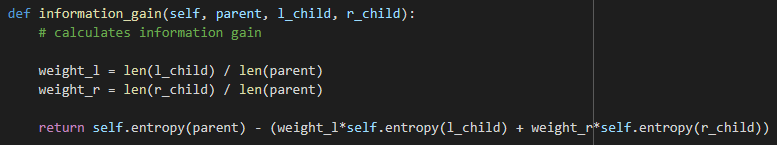



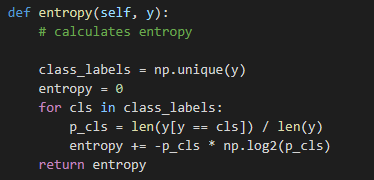

The variance reduction for a split at a node is calculated as the difference between the variance of the target variable in the parent node and the sum of the variances of the target variable in the child nodes, weighted by the number of samples in each child node.

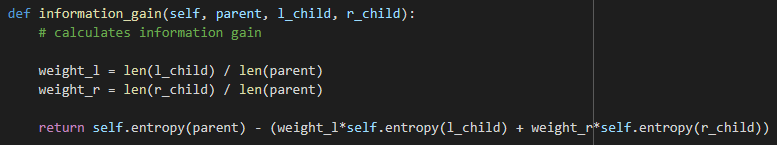

*Classification:* Entropy is used. 
*Regression:* Variance reduction is used.

Printing the tree is the same for both of them.

build_dt, build_rdf, predict_dt, predict_rdf functions are used inside the DecisionTree class.

build_dt and build_rdf functions call build_tree function with a task value which determines if this is a classification or regression. build_tree function is a recursive function (which is the best way to build trees). get_best_split function splits the tree according to found godness values which is found by the methods I described before (variance reduction and entropy).

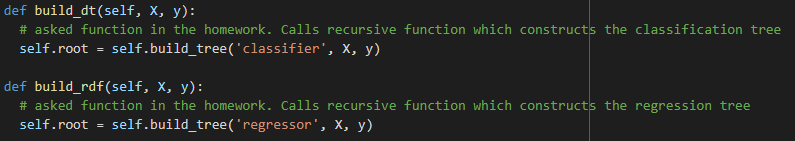

Actually, there is no distinction between predict_dt and predict_rdf in my implementation, but still I used distinct functions for the sake of completeness.

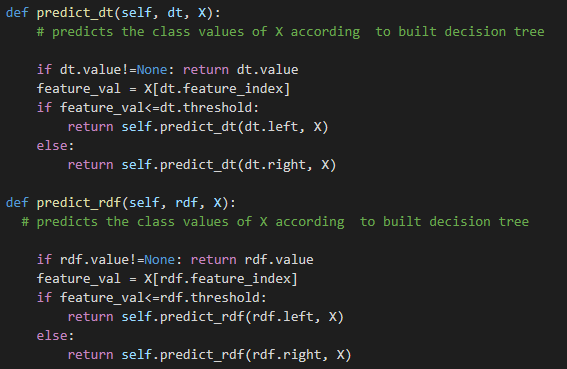

The pruning method I used in this homework is pre-pruning. Which can be used by selecting min_samples_split and max_depth values. By default, both of them are 2.
If there are 2 samples in a node or if the depth of the tree is bigger than max_depth, a subtree will not be constructed. These values can be determined by the constructor of DecisionTree.

**NOTE:** Confusion matrix is not applicable for regression so I didn't implement it in regression. I assume that there is a mistake in the homework document.

**K-Fold Cross Validation:** I had to write my own function to implement k-fold cross validaion:

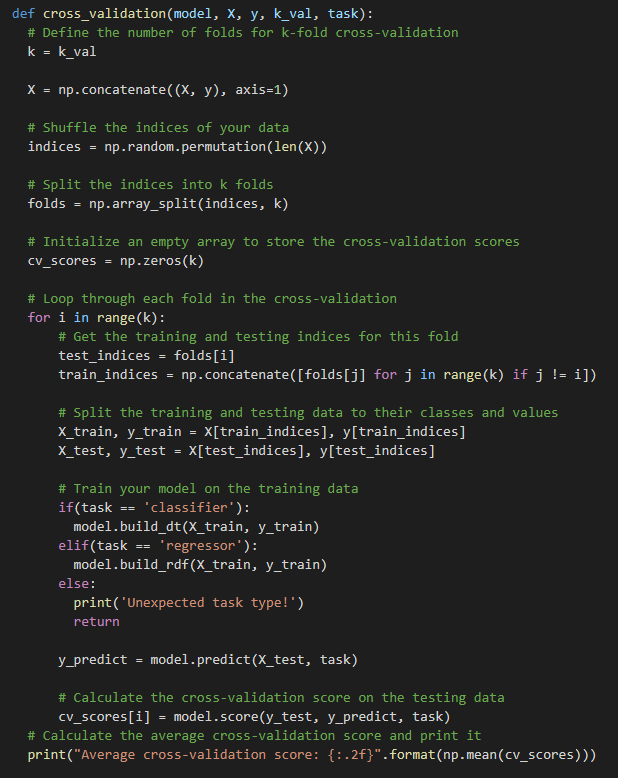

k-val indicates k value and task indicates if the decision tree is a classifier or a regressor.

**Result:**

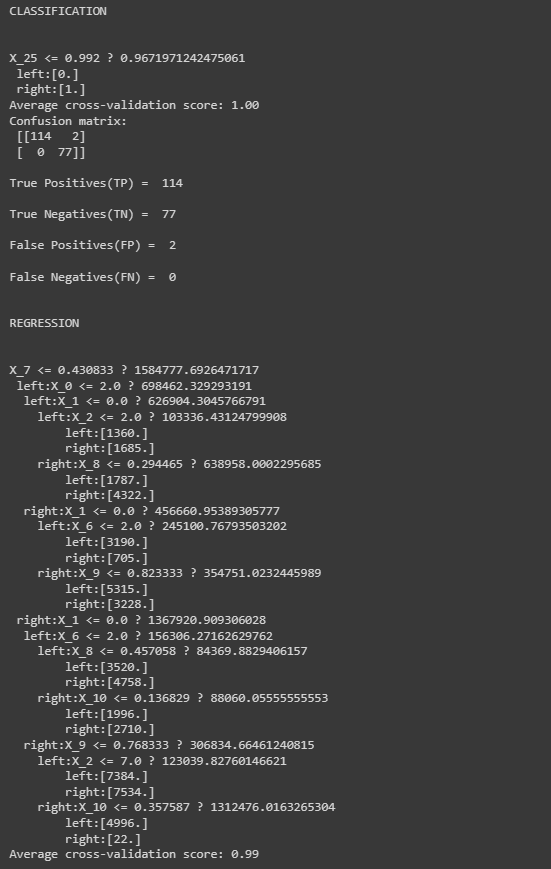

Both classification and regression trees work perfectly. Probably there is overfitting. Or it can be about the data we have. The decisions that were made can be seen by looking at the x values. They represent the column numbers.